# CR3BP low-thrust

In this tutorial we show the use of the {class}`pykep.trajopt.direct_nd` to find a low-thrust (zero-order hold continuous thrust) trajectory connecting two orbits in the circular restricted 3-body problem (CR3BP). 

The decision vector for this class, compatible with pygmo {cite:p}`pagmo` UDPs (User Defined Problems), is:

$$
\mathbf x = [t_0, m_f, V_{sx}^\infty, V^\infty_{sy}, V^\infty_{sz}, V^\infty_{fx}, V^\infty_{fy}, V^\infty_{fz}, u_{x0}, u_{y0}, u_{z0}, u_{x1}, u_{y1}, u_{z1}, ..., T_{tof}]
$$

containing the starting epoch $t_0=0$, the final mass $m_f$ as well as the starting and final $V^{\infty}$, throttles and the time-of-flight $T_{tof}$.

:::{note}
This notebook makes use of the commercial solver SNOPT 7 and to run needs a valid `snopt_7_c` library installed in the system. In case SNOPT7 is not available, you can still run the notebook using, for example `uda = pg.algorithm.nlopt("slsqp")` with minor modifications.

Basic imports:

In [18]:
import pykep as pk
import numpy as np
import time
import pygmo as pg
import pygmo_plugins_nonfree as ppnf
import time

from matplotlib import pyplot as plt

We start defining the problem data. For the purpose of this notebook we choose a transfer between two periodic orbits of the same family.

In [19]:
# Problem data
mu = pk.MU_MOON / (pk.MU_EARTH + pk.MU_MOON)
max_thrust = 1
isp = 1500.
veff = isp * pk.G0

# Initial state
ms = 1500.0
rs = np.array([1.0809931218390707,0.0,-0.20235953267405354])
vs = np.array([0.0,-0.19895001215078018,0.0])

# Final state
mf = 1300.0
rf = np.array([1.1648780946517576,0.0,-0.11145303634437023])
vf = np.array([0.0,-0.20191923237095796,0.0])

# Segments and tof
nseg = 10
cut = 0.6

tof = 15 * pk.DAY2SEC

In [20]:
# Normalise
L = 384400e3
TIME = np.sqrt(L**3 / (pk.MU_EARTH+pk.MU_MOON))
VEL = L / TIME
ACC = VEL / TIME
MASS = ms

print(f'Normalise L {L:.4f} T {TIME:.4f} V {VEL:.4f} M {MASS:.4f}')

# Problem data
# mu already in non-dimensional units
max_thrust = max_thrust / (MASS * L / TIME**2)
veff = veff / VEL

# Initial state
ms = ms / MASS
# rs already in non-dimensional units
# vs already in non-dimensional units

# Final state
mf = mf / MASS
# rf already in non-dimensional units
# vf already in non-dimensional units

# tof
tof = tof / TIME

Normalise L 384400000.0000 T 375190.2619 V 1024.5468 M 1500.0000


Convert final position and velocity into an orbit

In [22]:
posvel0 = [
    rs.tolist(),
    vs.tolist()
]

# Propagate backwards to t0
ta = pk.ta.get_cr3bp(1e-16)
ta.pars[0] = mu
ta.time = tof
ta.state[:6] = rf.tolist() + vf.tolist()

tgrid = np.linspace(tof,0.0,10)
sol = ta.propagate_grid(tgrid)
integration = sol[5]

rf_0 = integration[-1,:3]
vf_0 = integration[-1,3:6]

posvelf = [
    rf_0.tolist(),
    vf_0.tolist()
]

print(f'IC {rf_0} {vf_0} t {ta.time}')
print(f'FC {rf} {vf} t {tof}')


IC [ 1.16286872  0.03020472 -0.10900863] [ 0.02640623 -0.19575618 -0.0322854 ] t 0.0
FC [ 1.16487809  0.         -0.11145304] [ 0.         -0.20191923  0.        ] t 3.4542474355687673


We initialise the taylor adaptive integrators for the dynamics of choice (here the zero-hold cr3bp)

In [23]:
ta = pk.ta.get_zero_hold_cr3bp(1e-16)
ta_var = pk.ta.get_zero_hold_cr3bp_var(1e-16)

We here instantiate a UDP (User Defined Problem), with analytical gradients, for this CR3BP transfer. Here the times are all fixed ($t_0$ and tof), but they can be allowed to vary. 

In [24]:
udp_g = pk.trajopt.direct_nd(
        pls=posvel0,
        plf=posvelf,
        ms=ms,
        mu=mu,
        max_thrust=max_thrust,
        veff=veff,
        t0_bounds=[0.0, 0.0],
        tof_bounds=[tof,tof],
        mf_bounds=[ms*0.5, ms],
        vinfs=0.,
        vinff=0.,
        nseg=nseg,
        cut=cut,
        with_gradient=True,
        high_fidelity=True,
        tas = (ta, ta_var)
)

In [25]:
# We need to generate a random chromosomes compatible with the UDP where to test the gradient.
prob_g = pg.problem(udp_g)
prob_g.c_tol = 1e-6
pop_g = pg.population(prob_g, 1)

Here is the random initial guess

(-0.5, 0.5)

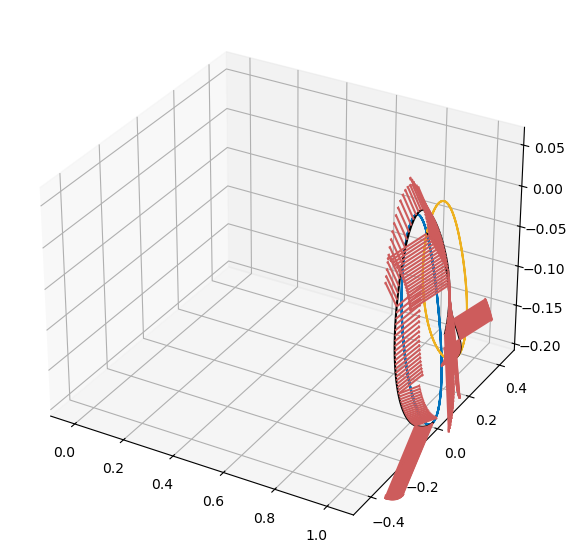

In [26]:
ax = udp_g.plot(pop_g.champion_x, show_gridpoints=False, show_throttles=True, show_midpoints=False)
# Making the axes nicer
ax.set_xlim(-0.1,1.1)
ax.set_ylim(-1/2,1/2)
# ax.view_init(90,-90)
# ax.axis('off');

## Analytical performances of the gradient

Compare gradient accuracy to verify it works

In [27]:
# Check gradientss
# Analytical
an_grad = udp_g.gradient(pop_g.champion_x)
# Numerical
num_grad = pg.estimate_gradient_h(udp_g.fitness, pop_g.champion_x, dx=1e-8)

# Suppose sparsity gives the positions (flat indices in num_grad)
sparsity = udp_g.gradient_sparsity()  # e.g. [0, 3, 10, ...]

# Make an empty dense gradient
dim = int(9+3*nseg)
dense_ana_grad = np.zeros_like(num_grad).reshape(int(len(num_grad)/dim),dim)
num_grad = num_grad.reshape(int(len(num_grad)/dim),dim)

# Fill in analytical entries at the right positions
for jj in range(len(an_grad)):
    dense_ana_grad[sparsity[jj][0], sparsity[jj][1]] = an_grad[jj]
    diff_tmp = abs(dense_ana_grad[sparsity[jj][0], sparsity[jj][1]] - num_grad[sparsity[jj][0], sparsity[jj][1]])
    if diff_tmp > 1e-3:
        print('sparsity[jj]',sparsity[jj] , 'analytical', dense_ana_grad[sparsity[jj][0], sparsity[jj][1]],'numerical', num_grad[sparsity[jj][0], sparsity[jj][1]],'diff',diff_tmp)

# Now you can compare
diff_bool = np.allclose(num_grad, dense_ana_grad, atol=1e-3, rtol=1e-3)
diff = num_grad - dense_ana_grad

print('diff_bool', diff_bool)
print('shape(diff)', np.shape(diff))
print("‖diff‖:", np.linalg.norm(diff))

diff_bool True
shape(diff) (20, 39)
‖diff‖: 3.17430528231e-06


The analytical gradient its exact and faster, seems like a no brainer to use it. 

In reality, the effects on the optimization technique used are not straightforward, making the option to use numerical gradients still interesting in some, albeit rare, cases.

## Solving the low-thrust transfer

We define (again) the optimization problem, and set a tolerance for *pagmo* to be able to judge the relative value of two individuals. 

:::{note}
This tolerance has a different role from the numerical tolerance set in the particular algorithm chosen to solve the problem and is only used by the *pagmo* machinery to decide outside the optimizer whether the new proposed indivdual is better than what was the previous *champion*.

In [28]:
prob_g = pg.problem(udp_g)
prob_g.c_tol = 1e-6

... and we define an optimization algorithm.

In [ ]:
snopt72 = "/Users/dario.izzo/opt/libsnopt7_c.dylib"
uda = ppnf.snopt7(library=snopt72, minor_version=2, screen_output=False)
uda.set_integer_option("Major iterations limit", 2000)
uda.set_integer_option("Iterations limit", 20000)
uda.set_numeric_option("Major optimality tolerance", 1e-3)
uda.set_numeric_option("Major feasibility tolerance", 1e-8)

algo = pg.algorithm(uda)

We solve the problem from random initial guess ten times and only save the result if a feasible solution is found (as defined by the criterias above)

In [30]:
print('--------------------------')
print(f'Testing Nseg {nseg}')
total_time = 0.0

ntotal = 10
errs = []
obj = []
xs = []
successes = []
average_time = []

for i in range(ntotal):
    time_start = time.time()

    pop_g = pg.population(prob_g, 1)
    
    pop_g = algo.evolve(pop_g)
    
    time_end = time.time()
    average_time.append(time_end - time_start)
    total_time += time_end - time_start
    
    # print('err', np.linalg.norm(pop_g.champion_f[1:]), np.linalg.norm(pop_g.champion_f[1:4]), np.linalg.norm(pop_g.champion_f[4:7]))
    if(prob_g.feasibility_f(pop_g.champion_f)):
        print(".", end="")
        obj.append(pop_g.champion_x[1])
        xs.append(pop_g.champion_x)
        successes.append(1)
        # break
    else:
        print("x", end ="")

if len(obj)>0:
    print("\nBest mass is: ", np.max(obj))
    print(f"Total time to success: {total_time:.3f} seconds")
    print(f"mean time {np.mean(np.array(average_time)):.4g} s")
    print(f"median time {np.median(np.array(average_time)):.4g} s")
    print(f"std time {np.std(np.array(average_time)):.4g} s")
    best_idx = np.argmax(obj)
else:
    xs = [pop_g.champion_x]
    best_idx = 0
    successes.append(0)
    obj.append(np.nan)
    print("\nNo solution found")

best_x = xs[best_idx]

--------------------------
Testing Nseg 10
.........x
Best mass is:  0.982905643805
Total time to success: 17.997 seconds
mean time 1.8 s
median time 0.839 s
std time 1.631 s


And we print information from the trajectory found:

In [31]:
udp_g.pretty(best_x)


Low-thrust NEP transfer
Departure: [[1.0809931218390707, 0.0, -0.20235953267405354], [0.0, -0.19895001215078018, 0.0]]
Arrival: [[1.162868724796319, 0.03020472227472182, -0.10900862799578588], [0.026406227292583073, -0.1957561800940141, -0.03228539905840568]]

Launch epoch: 0.00000
Arrival epoch: 3.45425
Time of flight (-): 3.45425 

Launch DV (-) 0.00000000 - [-0.0,-0.0,-0.0]
Arrival DV (-) 0.00000000 - [-0.0,-0.0,-0.0]
Final mass (mf/m0): 0.9829056438046061

Details on the low-thrust leg: (NEEDS fixing) 
Number of segments: 10
Number of fwd segments: 6
Number of bck segments: 4
Maximum thrust: 0.2441341183152667
Central body gravitational parameter: 0.01215058439470971
Specific impulse: 14.357542592908132

Time of flight: 3.4542474355687673
Initial mass: 1
Final mass: 0.9829056438046061
State at departure: [[1.0809931218390707, 0, -0.20235953267405354], [0, -0.19895001215078018, 0]]
State at arrival: [[1.1648780946518202, -1.6328682959466218e-14, -0.11145303634438145], [9.7840472778

And plot the results

Text(0.5, 0, 'z')

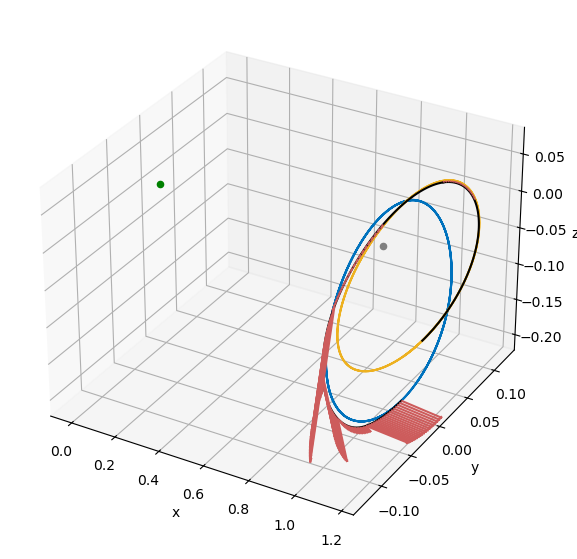

In [32]:
ax = udp_g.plot(best_x, show_gridpoints=False, show_throttles=True, show_midpoints=False)
# Making the axes nicer
ax.scatter(-mu, 0, 0, c="green", s=20)
ax.scatter(1-mu, 0, 0, c="gray", s=20)
# ax.set_xlim(-0.1,1.1)
# ax.set_ylim(-1/2,1/2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# ax.view_init(90,-90)
# ax.axis('off');


And the throttle/control profile

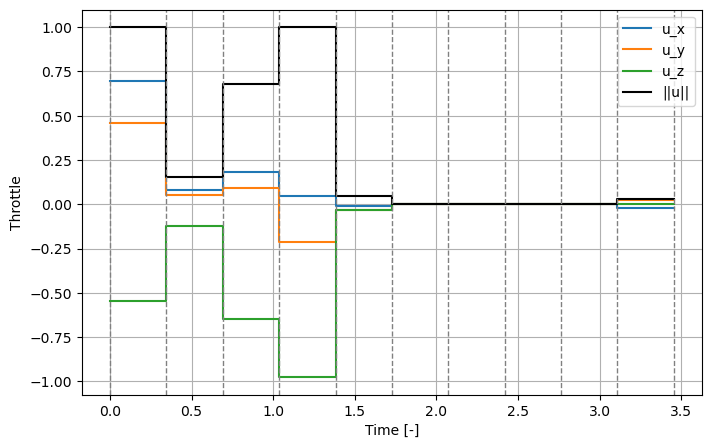

In [ ]:
# Extract throttle values from the best solution
tgrid = np.linspace(best_x[0], best_x[-1], int(len(best_x[8:-1])/3)+1)
throttle_profile = best_x[8:-1].reshape(int(len(best_x[8:-1])/3), 3)

fig, ax = plt.subplots(figsize=(8, 5))

# Plot thrust profiles
ax.step(tgrid, np.hstack((throttle_profile[:, 0], throttle_profile[-1, 0])), label='u_x', where='post')
ax.step(tgrid, np.hstack((throttle_profile[:, 1], throttle_profile[-1, 1])), label='u_y', where='post')
ax.step(tgrid, np.hstack((throttle_profile[:, 2], throttle_profile[-1, 2])), label='u_z', where='post')
ax.step(
    tgrid,
    np.hstack((
        np.linalg.norm(throttle_profile[:, 0:3], axis=1),
        np.linalg.norm(throttle_profile[-1, 0:3])
    )),
    color='k', label='||u||', where='post'
)

# Add vertical grid lines
for t in tgrid:
    ax.axvline(x=t, color='gray', linestyle='--', linewidth=1.0)

# Labels, legend, and grid
ax.set_xlabel('Time [-]')
ax.set_ylabel('Throttle')
# ax.set_title(f'Thrust Profile: Obj {obj:.4f}')
ax.legend()
ax.grid(True)
